# Neural Network Analysis

In [105]:
!pip install jdc
import jdc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
from sklearn.metrics import r2_score

from math import sqrt
from numpy import mean
from numpy.random import rand


Defaulting to user installation because normal site-packages is not writeable


## Define Class

In [342]:
# activation functions
def sigmoid(x=0, deriv=False):
    sigmoid=1/(1+np.exp(-x))
    if(deriv==True):
        return sigmoid*(1-sigmoid)
    return sigmoid

def sigmoid2(x,deriv=False):
    sigmoid=1.2/(1.0+np.exp(-x))
    if(deriv==True):
        return 1.2*sigmoid*(1-sigmoid)
    return sigmoid

def sin(x=0, deriv=False):
    if(deriv==True):
        return np.cos(x)
    return np.sin(x)

def linear(x=0, deriv=False):
    if(deriv==True):
        return 1
    return x

In [343]:
class neural_net:    
    def __init__(self):
        # inputs
        self.nodes_tracker = defaultdict() # tracks {layer_num: num_nodes}
        self.act_tracker = defaultdict() # tracks {layer_num: activation_function}
        self.lr_tracker = defaultdict() # tracks {layer_num: gamma/learning_rate}  
        self.weights = defaultdict() # tracks weights from previous layer to next {prev_layer: weights to next layer}              
        
        # training
        self.feed_fwd_tracker = defaultdict() # tracks feed forward {layer_num:feed_forward values}
        self.delta_tracker = defaultdict() # tracks delta for weight updates {layer_num:delta values}        
        
        # others
        self.layer_num = 0 # +1 for every hidden layer added
        self.act_func_list = {'sin':sin, 'sigmoid':sigmoid, 'sigmoid2':sigmoid2, 'linear':linear} # activation functions
        self.errors = []
        self.metric = []
        self.reset_weights = True # becomes false when we load weights

In [344]:
%%add_to neural_net
def add_input_layer(self, num_inputs):
    self.nodes_tracker[f'layer_{self.layer_num}'] = num_inputs
    self.layer_num += 1 # for next hidden layer    

def add_layer(self, num_nodes, activation='sigmoid', learning_rate=0.01): # has bugs for > 2 hidden layers
    self.nodes_tracker[f'layer_{self.layer_num}'] = num_nodes
    self.act_tracker[f'layer_{self.layer_num}'] = self.act_func_list[activation]    
    self.lr_tracker[f'layer_{self.layer_num}'] = learning_rate
    self.layer_num += 1 # for next hidden layer       
    self.num_layers = len(self.nodes_tracker.keys())         

In [345]:
%%add_to neural_net
# can implement xavier-glorot later
def init_weights(self, init_method=None):    
    '''initialize weights'''
    
    for i in range(self.num_layers-1):
        np.random.seed(i)
        prev_layer = f'layer_{i}'
        next_layer = f'layer_{i+1}'
        self.weights[prev_layer] = 2*np.random.random((self.nodes_tracker[prev_layer],self.nodes_tracker[next_layer])) - 1
    
    
    
    # xavier-glorot         
    if init_method == 'xavier_glorot':
        for i in range(self.num_layers-1):
            np.random.seed(i)
            prev_layer = f'layer_{i}'
            next_layer = f'layer_{i+1}'

            # calculate the range for the weights
            no_inputs = self.nodes_tracker[prev_layer]
            no_outputs = self.nodes_tracker[next_layer]
            lower, upper = -(1.0 / sqrt(no_inputs)), (1.0 / sqrt(no_inputs)) 

            # generate random numbers
            numbers = rand(no_inputs * no_outputs)    

            # weights
            self.weights[prev_layer] = np.array(lower + numbers * (upper - lower)).reshape((no_inputs,no_outputs))        


In [346]:
%%add_to neural_net
def feed_forward(self):
    # Feed forward through layers 0, 1, and 2    
    # initialize with training data

    # Template:
    # layer0 = X
    # layer1 = nonlin(np.dot(layer0,w0))  

    self.feed_fwd_tracker['layer_0'] = self.X_train # input from fit function
    
    for i in range(0, self.num_layers-1):
        prev_layer = f'layer_{i}'
        next_layer = f'layer_{i+1}'       
        
        prev_next_vals = np.dot(self.feed_fwd_tracker[prev_layer], self.weights[prev_layer])        
        self.feed_fwd_tracker[next_layer] = self.act_tracker[next_layer](prev_next_vals)

In [347]:
%%add_to neural_net
def predict(self, X):
    # Feed forward through layers 0, 1, and 2    
    # initialize with training data

    # Template:
    # layer0 = X
    # layer1 = nonlin(np.dot(layer0,w0))      
    
    feed_fwd_tracker_predict = {k:v for k, v in self.feed_fwd_tracker.items()}
    feed_fwd_tracker_predict['layer_0'] = X # input from fit function
    
    for i in range(0, self.num_layers-1):
        prev_layer = f'layer_{i}'
        next_layer = f'layer_{i+1}'       
        
        prev_next_vals = np.dot(feed_fwd_tracker_predict[prev_layer], self.weights[prev_layer])        
        feed_fwd_tracker_predict[next_layer] = self.act_tracker[next_layer](prev_next_vals)
    
    return feed_fwd_tracker_predict[next_layer]

In [348]:
%%add_to neural_net
def backprop(self):
    
    # get delta from last layer    
    # Template: layer3_delta = layer3_error*nonlin(np.dot(layer2,w2),deriv=True)
    last_layer_name = f'layer_{self.layer_num-1}' # e.g. 4th layer is layer_3
    prev_layer_name = f'layer_{self.layer_num-2}' # e.g. 3rd layer is layer_2
    
    last_layer_ff = self.feed_fwd_tracker[last_layer_name] 
    prev_layer_ff = self.feed_fwd_tracker[prev_layer_name]    
    prev_layer_weights = self.weights[prev_layer_name]        

    dot_val = np.dot(prev_layer_ff, prev_layer_weights)    
    self.delta_tracker[last_layer_name] = self.error * self.act_tracker[last_layer_name](dot_val, deriv=True)
    
    # propagate gradients the previous layers
    # Template: layer2_delta = layer3_delta.dot(w2.T)*nonlin(np.dot(layer1,w1),deriv=True)    
    for i in np.arange(self.num_layers-1, 1, -1):
        next_layer_name = f'layer_{i}' # e.g. layer 3     
        current_layer_name = f'layer_{i-1}' # e.g. layer 2
        prev_layer_name = f'layer_{i-2}' # e.g. layer 1
        
        next_layer_ff = self.feed_fwd_tracker[next_layer_name] 
        current_layer_ff = self.feed_fwd_tracker[current_layer_name]    
        current_layer_weights = self.weights[current_layer_name]
        
        prev_layer_ff = self.feed_fwd_tracker[prev_layer_name]    
        prev_layer_weights = self.weights[prev_layer_name]        
                
        part_a = self.delta_tracker[next_layer_name].dot(current_layer_weights.T)
        part_b = np.dot(prev_layer_ff, prev_layer_weights)    
        part_c = self.act_tracker[current_layer_name](part_b, deriv=True)
        self.delta_tracker[current_layer_name] = part_a * part_c
        
    # update weights
    # Template: w2 += gamma2*layer2.T.dot(layer3_delta)
    for i in range(self.layer_num-1):
        
        # we want to update weights from next layer to next {prev_layer: weight to next}
        
        next_layer_name = f'layer_{i+1}' # e.g. layer 3     
        current_layer_name = f'layer_{i}' # e.g. layer 2
        
        gamma = self.lr_tracker[next_layer_name] # learning rate to next layer
        current_layer_ff = self.feed_fwd_tracker[current_layer_name] # feed forward value  
        next_layer_delta = self.delta_tracker[next_layer_name] # delta from next layer
        
        self.weights[current_layer_name] += gamma * current_layer_ff.T.dot(next_layer_delta)        

In [349]:
%%add_to neural_net
def load_weights(self, path):
    """
    load weights in pkl format
    """
    
    self.weights = joblib.load(path)    
    self.reset_weights = False
    

In [419]:
%%add_to neural_net
def fit(self, X_train, y_train, X_valid, y_valid, train_iter, 
        init_method=None, metric='r2', early_stopping = 100, verbose=False):
    self.X_train = X_train
    self.y_train = y_train 
    self.X_valid = X_valid
    self.y_valid = y_valid
    
    # last_layer name
    self.last_layer = f'layer_{len(self.nodes_tracker.keys())-1}'
    
    # initialize weights
    if self.reset_weights:
        self.init_weights(init_method=init_method)
        
    self.best_iter = 0
    no_improvement_count = 0    
    self.best_weights_list = [0]
    self.best_metrics_list = [-999]    
        
    for i in range(train_iter):
        # feed forward
        self.feed_forward()
        
        # Error Function
        # self.error = self.y_train - self.feed_fwd_tracker[self.last_layer]
        self.error = self.y_train - self.predict(self.X_train)
                
        error_ = np.mean(np.abs(self.error))
        self.errors.append(error_)       
        
        # accuracy on validation set
        if metric=='r2':        
            y_pred = self.predict(self.X_valid).flatten()
            metric_ = r2_score(y_pred, self.y_valid)
            self.metric.append(metric_) 
            
        if metric_ > self.best_metrics_list[-1]:
            self.best_iter = i
#             self.best_weights = self.weights.copy()
            self.best_metrics_list.append(metric_)
            self.best_weights_list.append(self.weights)
            
#             joblib.dump(self.weights, f'weights/weights_{i}_{np.round(self.best_val_metric, 4)}.pkl')
#             self.best_weights = {k:v for k, v in self.weights.items()}
            no_improvement_count = 0 # reset this count
                
        if (i%(train_iter//20)) == 0:                                                              
            if verbose: # reporting has a bug  
                print ("Num iters", i,
                       "Train Error =", np.round(error_, 3), 
                       "valid metric =", np.round(metric_, 3), 
                       "best_iter", self.best_iter, 
                       "best val", np.round(self.best_metrics_list[-1], 3))
                
        # backprop
        self.backprop()        
        no_improvement_count += 1
        
        # stop if there's no improvement
        if no_improvement_count > early_stopping:
            break

    ind_ = np.argmax(self.best_metrics_list)
    self.best_weights = self.best_weights_list[ind_]
    

## Load the Data

In [416]:
# !pip install openpyxl

In [355]:
df_bikesharing = pd.read_excel('Bike_Sharing_day.xlsx', sheet_name="day", engine='openpyxl')
dummy=df_bikesharing
dummy.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [356]:
df_features=dummy.drop('count', axis=1)
df_features=df_features.drop('instant', axis=1)
df_features=df_features.drop('dteday', axis=1)
len(df_features)
df_features.head(5)

X = df_features
y = dummy['count']



##Run this if you want to scale the input and output 

'''yy=np.reshape(y, (-1,1))

from sklearn.preprocessing import MinMaxScaler
sscaler = MinMaxScaler()
X = sscaler.fit_transform(X)
y = sscaler.fit_transform(yy)'''

'yy=np.reshape(y, (-1,1))\n\nfrom sklearn.preprocessing import MinMaxScaler\nsscaler = MinMaxScaler()\nX = sscaler.fit_transform(X)\ny = sscaler.fit_transform(yy)'

In [357]:
X.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


In [148]:
X.insert(loc=0, column='biased', value=1.0)

In [149]:
X.head()

,biased,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1.0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,1.0,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1.0,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1.0,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1.0,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


### Important stroke: Scale the output!

In [150]:
y_highest = y.max()

In [151]:
y=y/y.max()

In [152]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 )

In [153]:
y_train=np.array(y_train, ndmin=2).T

In [154]:
len(y_train)

548

In [155]:
X=X_train.values
y=y_train

no_inputs=len(X[0])

## Train

In [420]:
gamma1=.01 #input to hidden bigger
gamma2=.001 #Hidden to Output smaller

In [455]:
np.random.seed(42)

nn = neural_net()
nn.add_input_layer(no_inputs) # input layer
nn.add_layer(8, activation='sigmoid', learning_rate=0.01)
nn.add_layer(9, activation='sigmoid', learning_rate=0.01)
nn.add_layer(1, activation='sigmoid2', learning_rate=0.001) # output layer

# errors printed by verbose has a bug
nn.fit(X_train, y_train, X_test.values, y_test, init_method=None, 
       train_iter=500, early_stopping = 50000, metric='r2', verbose=True)


In [456]:
plt.plot(nn.errors, label='training error')
plt.show()
plt.semilogx()
plt.plot(nn.metric, label='r2')

In [457]:
nn.best_metrics_list[-5:]

In [458]:
# load best weights
# this is buggy
print(nn.weights == nn.best_weights_list[-1])
nn.weights = nn.best_weights

In [459]:
nn.best_weights_list[-2] == nn.best_weights_list[-1]

In [463]:
y_pred = nn.predict(X_test)
r2_score(y_pred, y_test) 

0.9031862276246608

R2 score = 0.903186


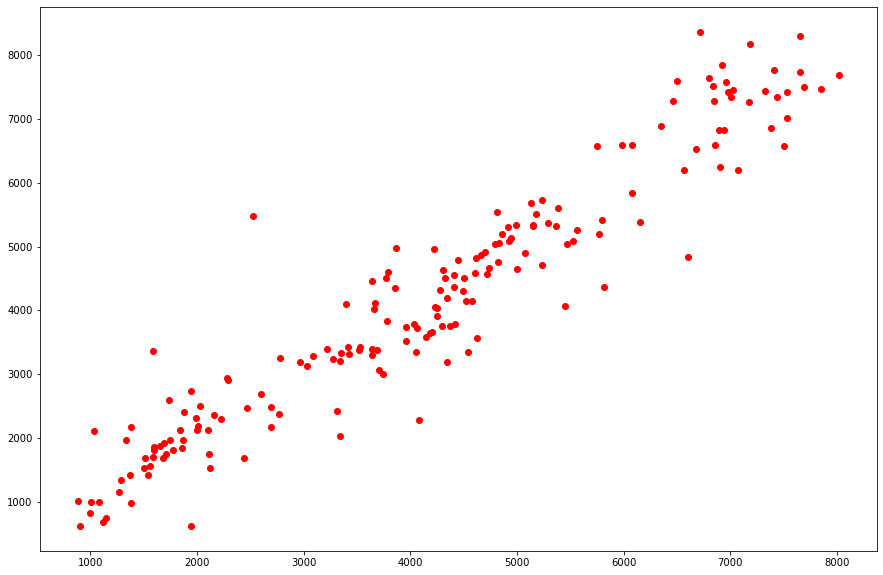

In [406]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(y_highest*y_pred,y_highest*y_test, c="r", label="test (actual) data")
print("R2 score = %f"%r2_score(y_highest*y_pred, y_highest*y_test))

In [206]:
# import joblib

# # let's save the weights
# weights = nn.weights
# joblib.dump(weights, 'weights.pkl')

['weights.pkl']

## Refining from pretrained weights

In [264]:
gamma1=.001 #input to hidden bigger
gamma2=.0001 #Hidden to Output smaller

In [464]:
np.random.seed(42)

nn = neural_net()
nn.add_input_layer(no_inputs) # input layer
nn.add_layer(8, activation='sigmoid', learning_rate=gamma1)
nn.add_layer(9, activation='sigmoid', learning_rate=gamma1)
nn.add_layer(1, activation='sigmoid2', learning_rate=gamma2) # output layer

# load weights
nn.load_weights('weights.pkl')

In [266]:
nn.fit(X_train, y_train, X_test.values, y_test, init_method=None, 
       train_iter=10000, early_stopping = 2000, metric='r2', verbose=True)

Num iters 0 Train Error = 0.04 valid metric = 0.903 best_iter 0 best val 0.903
Num iters 500 Train Error = 0.04 valid metric = 0.9 best_iter 0 best val 0.903
Num iters 1000 Train Error = 0.04 valid metric = 0.9 best_iter 0 best val 0.903
Num iters 1500 Train Error = 0.04 valid metric = 0.9 best_iter 0 best val 0.903
Num iters 2000 Train Error = 0.04 valid metric = 0.9 best_iter 0 best val 0.903


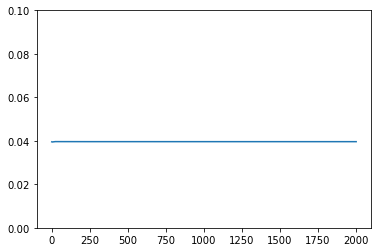

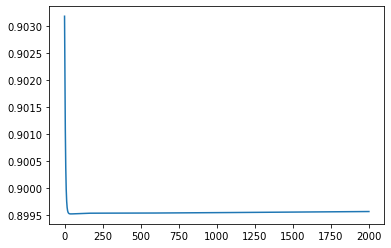

In [267]:
plt.plot(nn.errors, label='training error')
plt.ylim(0, 0.1)
plt.show()
plt.plot(nn.metric, label='r2')

In [269]:
nn.weights = nn.best_weights

R2 score = 0.903691


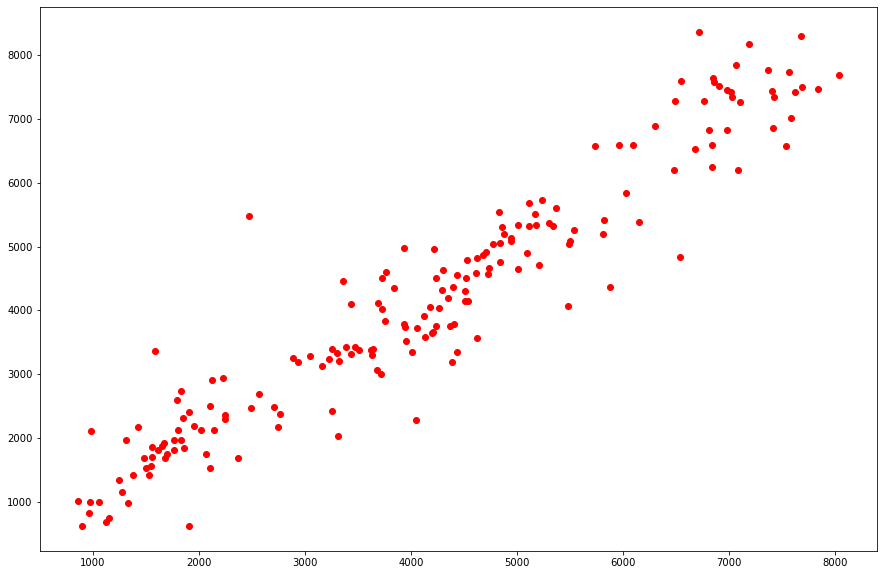

In [465]:
y_pred = nn.predict(X_test)
fig = plt.figure(figsize=(15, 10))
plt.scatter(y_highest*y_pred,y_highest*y_test, c="r", label="test (actual) data")
print("R2 score = %f"%r2_score(y_highest*y_pred, y_highest*y_test))

In [104]:
# save weights
joblib.dump(nn.weights, 'weights2.pkl')

['weights2.pkl']

## Hyperparameter search

In [43]:
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt

#create df of possible combinations of nodes
nodes = [4, 6]
df_combs = pd.DataFrame()
for num_hid_layer in [1]:
    df_layer_node = pd.DataFrame()
    num_nodes = list(it.product(nodes, repeat=num_hid_layer)) 
    df_layer_node['num_nodes'] = num_nodes
    df_layer_node['num_hid_layer'] = num_hid_layer
        
    df_combs = pd.concat([df_combs, df_layer_node])
df_combs.reset_index(drop=True, inplace=True)
df_combs

,num_nodes,num_hid_layer
0,"(4,)",1
1,"(6,)",1


In [41]:
#iterate over df to feed in NN

# logs = {'labels':[], 'errors':[], 'metric_valid':[], 'final_error':[], 'final_metric':[]}
logs = {'labels':[], 'final_metric':[]}
k = 0

for index, row in df_combs.iterrows():
    print('combination', index)
    
    num_hidden = row.values[1]
    num_nodes = np.array([row.values[0]]).flatten()

    nn = neural_net()
    nn.add_input_layer(no_inputs) # input
    
    for i in range(num_hidden):
        nn.add_layer(num_nodes=num_nodes[i], activation='sigmoid', learning_rate=0.01)
        
    nn.add_layer(1, activation='sigmoid2', learning_rate=0.001) # output

    np.random.seed(42)
    nn.fit(X_train, y_train, X_test.values, y_test, train_iter=200000, metric='r2', verbose=False)    
    
    label = f"num hidden layers: {df_combs['num_hid_layer'].iloc[k]} num nodes: {df_combs['num_nodes'].iloc[k]}"
    k += 1
    
    logs['labels'] += [label]
#     logs['errors'] += [nn.errors]
#     logs['metric_valid'] += [nn.metric]   
#     logs['final_error'] += [nn.errors[-1]]

    y_pred = nn.predict(X_test)
    metric = r2_score(y_pred, y_test) 
    logs['final_metric'] += [metric]    
    print('validation metric', metric)

combination 0
validation metric -1.5988174199661205
combination 1
validation metric -0.21897986034185046


In [42]:
data = pd.DataFrame.from_dict(logs) # convert dictionary to dataframe
data

,labels,final_metric
0,"num hidden layers: 1 num nodes: (4,)",-1.598817
1,"num hidden layers: 1 num nodes: (6,)",-0.218980


R2 score = -0.218980


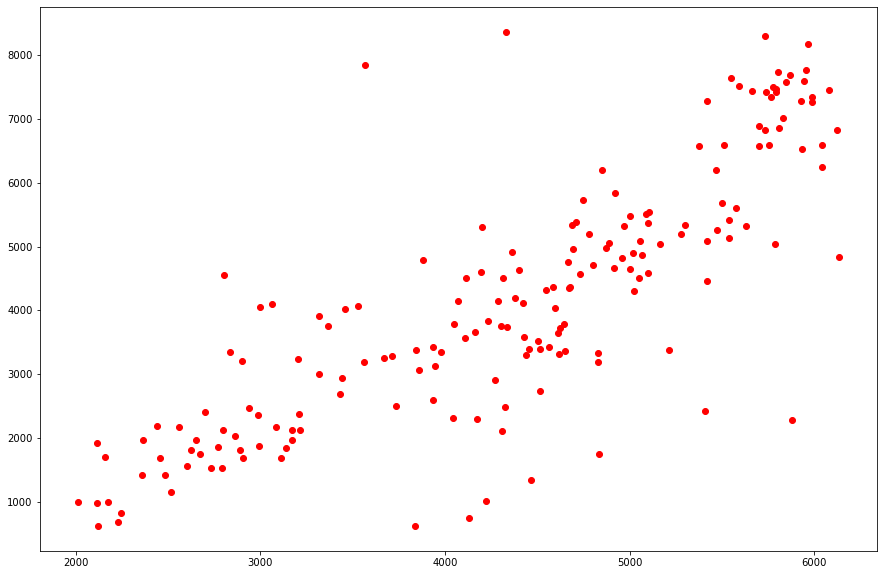

In [44]:
y_pred = nn.predict(X_test)
r2_score(y_pred, y_test) 

fig = plt.figure(figsize=(15, 10))
plt.scatter(y_highest*y_pred,y_highest*y_test, c="r", label="test (actual) data")
print("R2 score = %f"%r2_score(y_highest*y_pred, y_highest*y_test))
#print(accuracy_score(y_pred_LR,y_test))